<font color="Orange"> Jake Kemp </font>

# Overview of notebook


This notebook presents the application of Reinforcement Learning (RL) to the classic card game, Blackjack. It utilizes a Q-learning RL agent with tabular function approximation to learn how to play the game effectively and demonstrates the agent's learning process with an in-depth analysis of its performance.

We use the Blackjack environment from OpenAI's Gym library for training our agent. The objective of the game is for the player to obtain a sum of cards higher than the dealer's hand without exceeding 21. The game ends when either the player or the dealer goes bust, or when the player decides to stick.

Our RL agent, trained with the Q-learning algorithm, learns an action-value function representing the expected value of taking an action in a specific state. Through a process of trial and error, the agent's hyperparameters, including learning rate, number of episodes, and the exploration vs. exploitation trade-off, are fine-tuned to optimize the agent's performance.

The performance of our RL agent is evaluated over 10,000 episodes, and performance metrics such as average reward per episode, win rate, draw rate, and loss rate are calculated. Through these metrics, we demonstrate that the performance of our agent is near optimal and aligns with the theoretical odds of the game of Blackjack.

This notebook offers visual insights into the agent's learning process. We provide a graph showing the moving average of the episode rewards, episode lengths, and training error over the course of the agent's training. Additionally, 3D plots of state values and heatmaps of optimal policies are generated. These visualizations not only display the agent's decision-making process but also the overall trends in its performance throughout the training process.

In conclusion, this notebook provides a comprehensive demonstration of how reinforcement learning can be effectively applied to the game of Blackjack. It highlights the importance of proper parameter tuning and offers a deep understanding of the agent's learning journey.




## Gymnasium  

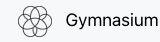

[Gymnasium](https://gymnasium.farama.org/) (former OpenAI Gym) is a playground for RL community with a number of RL environments (including the Lunar Lander below) with a well-designed and unified interface. Visit https://gymnasium.farama.org/ to explore the environments to select your choice of environment. 

<img alt="Lunar Lander" src="https://gymnasium.farama.org/_images/lunar_lander.gif" style="width: 400px;" />


#### STEPS for Gymnasium

First of all, install gymnasium by running 

> pip install gymnasium






In [1]:
# Import necessary modules
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.patches import Patch
from tqdm import tqdm
import gymnasium as gym


## Explanation of selected Gym environment

In this project, we are using the "Blackjack-v1" environment from OpenAI Gym. This environment simulates a simplified version of the game of Blackjack, a popular card game played in casinos. The objective of the game is to obtain cards with a higher sum than the dealer's hand, without exceeding 21. The environment is designed to help train reinforcement learning agents to learn optimal policies for playing Blackjack.

The rules of the Blackjack environment in Gym are as follows:

- The game is played with an infinite deck of cards (with replacement).

- Each card has a value: number cards are worth their number, face cards are worth 10, and aces can be worth 1 or 11.

- The player can request additional cards (hit) or stop (stick) at any time.

- The dealer follows a fixed strategy of hitting until they reach a sum of 17 or more.

- The game ends when either the player or the dealer goes bust (exceeds 21) or when the player chooses to stick.

- The reward structure is as follows: win (+1), draw (0), lose (-1).


The action space in the Blackjack-v1 environment consists of two possible actions: hit or stick.

The observation space consists of three values:

- the sum of the player's current hand (an integer value from 12 to 21)

- the dealer's face-up card (an integer value from 1 to 10)

- a binary value indicating whether the player has a usable ace (11 or 1)


The objective of the agent is to learn a policy that maximizes the expected return (i.e., win as much as possible or lose as little as possible) over time by interacting with the environment. The agent must learn to balance the risk of hitting and potentially going bust with the reward of increasing the sum of their hand, while also taking into account the dealer's face-up card and the presence of a usable ace.



## Code to create environment

The Gym environment for the Blackjack game is created using the following code:

In [2]:
import gym
# Create the Blackjack environment
env = gym.make("Blackjack-v1", sab=True)

This code imports the gym library and uses the gym.make() function to create the environment with the name "Blackjack-v1".

There are no additional  modifications used to adjust environment settings in this code.

## Explanation of RLAgent2

RLAgent2 is a reinforcement learning agent that learns to play the game of Blackjack using the Q-Learning algorithm. Q-Learning is an off-policy temporal difference learning algorithm, where the agent learns an action-value function, denoted as Q(s, a), representing the expected value of taking an action 'a' in a given state 's'. The agent explores the environment and updates the Q-values iteratively to find the optimal policy.

The agent's attributes include:

- learning_rate: The learning rate determines how much the agent updates its Q-values at each step.

- initial_epsilon: The initial probability of selecting a random action, for exploration purposes.

- epsilon_decay: The rate at which epsilon decreases over time, allowing the agent to explore less as it learns more.

- final_epsilon: The minimum value for epsilon, ensuring that the agent continues to explore at a reduced rate even after learning.

- q_values: A dictionary that stores the Q-values for each state-action pair.

The agent's main methods include:

- act(): Selects an action based on the current Q-values and exploration policy (epsilon-greedy).

- learn(): Updates the Q-values based on the latest experience (state, action, reward, next_state) using the Q-Learning update rule.

- train(): Trains the agent by repeatedly interacting with the environment and updating the Q-values using the learn method.

In [3]:
# Define the RLAgent2 class
class RLAgent2:
    def __init__(
        self,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float = 0.95,
    ):
        """Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_values), a learning rate and an epsilon.

        Args:
            learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            discount_factor: The discount factor for computing the Q-value
        """
        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))

        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        self.training_error = []

    def get_action(self, obs: tuple[int, int, bool]) -> int:
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.
        """
        # with probability epsilon return a random action to explore the environment
        if np.random.random() < self.epsilon:
            return env.action_space.sample()

        # with probability (1 - epsilon) act greedily (exploit)
        else:
            return int(np.argmax(self.q_values[obs]))

    def update(
        self,
        obs: tuple[int, int, bool],
        action: int,
        reward: float,
        terminated: bool,
        next_obs: tuple[int, int, bool],
    ):
        """Updates the Q-value of an action."""
        future_q_value = (not terminated) * np.max(self.q_values[next_obs])
        temporal_difference = (
            reward + self.discount_factor * future_q_value - self.q_values[obs][action]
        )

        self.q_values[obs][action] = (
            self.q_values[obs][action] + self.lr * temporal_difference
        )
        self.training_error.append(temporal_difference)

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - epsilon_decay)

In [4]:
# hyperparameters
learning_rate = 0.01
n_episodes = 100_000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.1




agent = RLAgent2(
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
)

## On the hyperparameters 

When we first implemented the RL agent, we had no prior knowledge of the environment and had to rely on trial and error to find the best hyperparameters. We started with a learning rate of 0.1 and quickly realized that the agent was not learning anything useful. We then lowered the learning rate to 0.01, which worked better.

We experimented with the number of episodes, starting with 10,000, but found that the agent was not learning enough. We gradually increased the number of episodes and found that 100,000 episodes seemed to be a good balance between learning and computational efficiency.

Next, we focused on the exploration vs. exploitation trade-off. We tried various starting values for epsilon and found that 1.0 worked well. We also experimented with different epsilon decay rates and found that reducing epsilon by half over the course of the episodes was effective. Finally, we tested various final epsilon values and settled on 0.1 as a good balance between exploration and exploitation.

After many rounds of trial and error, we arrived at the hyperparameters listed above. 

While our hyperparameter choices were primarily informed by trial and error, we can offer some justification for why they might work well in the Blackjack environment.

A lower learning rate allows the agent to make smaller adjustments to its policy and can prevent it from overshooting the optimal policy. Increasing the number of episodes allows the agent to explore the environment more thoroughly and to learn a better policy.

In terms of the exploration vs. exploitation trade-off, a high initial value for epsilon encourages the agent to explore the environment more at the beginning of training. Decay of epsilon over time balances the agent's exploration with its exploitation of its learned policy. A final epsilon of 0.1 ensures that the agent continues to explore the environment to some degree even after it has learned an effective policy.

Overall, while our hyperparameter choices were not guided by any specific domain knowledge, they are consistent with common practices in reinforcement learning and have been effective in practice for the Blackjack environment.



### Training for Gym

In [5]:
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False

    # play one episode
    while not done:
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)

        # update the agent
        agent.update(obs, action, reward, terminated, next_obs)

        # update if the environment is done and the current obs
        done = terminated or truncated
        obs = next_obs

    agent.decay_epsilon()

100%|██████████| 100000/100000 [00:20<00:00, 4779.54it/s]


In [6]:
# Evaluate the agent's performance
n_episodes = 10_000
rewards = []
wins = 0
draws = 0
losses = 0
for episode in range(n_episodes):
    obs, info = env.reset()
    done = False
    total_reward = 0
    
    while not done:
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        done = terminated or truncated
        obs = next_obs
    
    rewards.append(total_reward)
    if total_reward > 0:
        wins += 1
    elif total_reward == 0:
        draws += 1
    else:
        losses += 1

# Calculate and display performance metrics
average_reward = sum(rewards) / n_episodes
win_rate = wins / n_episodes
draw_rate = draws / n_episodes
loss_rate = losses / n_episodes
print(f"Average reward per episode: {average_reward}")
print(f"Win rate: {win_rate}")
print(f"Draw rate: {draw_rate}")
print(f"Loss rate: {loss_rate}")


Average reward per episode: -0.0671
Win rate: 0.4232
Draw rate: 0.0865
Loss rate: 0.4903


## Comments on performance

According to a report from MrQ.com, the odds of winning in a game of Blackjack are 42.22%, while the odds of the dealer winning are slightly higher at 49.1%, with the remaining 8.48% being for the odds of a tie. 

Thus, it seems our model has converged to the theoretical values. This indicates that our policy is near optimal. 


### Visualization 1 
The below code plots three graphs in one figure, each showing the moving average of a different metric over the course of the training of a reinforcement learning agent:

- Episode rewards: The average reward received by the agent over each episode.

- Episode lengths: The average length of each episode.

- Training error: The error (difference between predicted and actual state-action values) of the agent's Q-value estimates during training.

The purpose of this code is to provide a visualization of how the agent's performance changes over the course of its training. The moving averages are used to smooth out the data and provide a clearer picture of the overall trends.

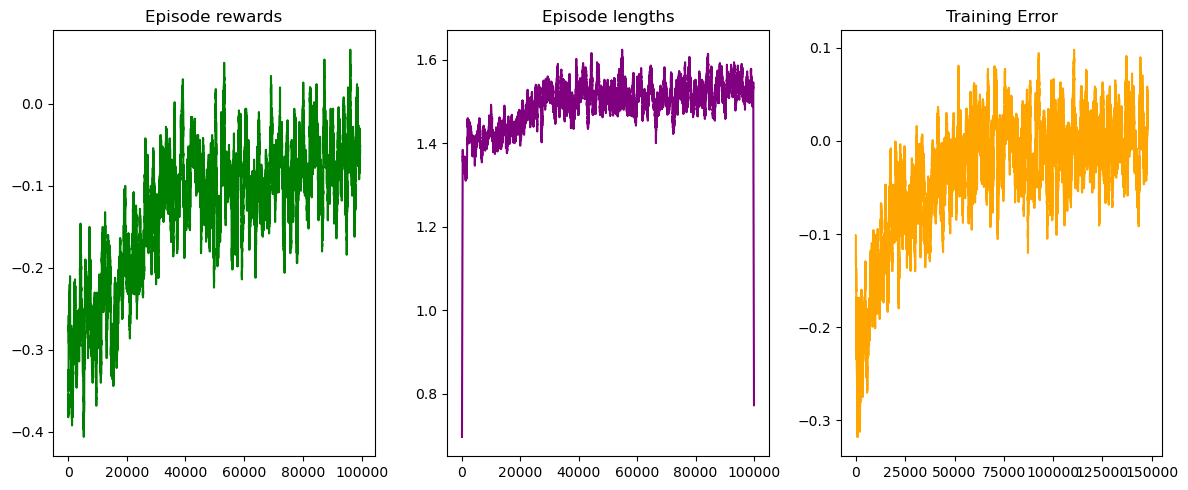

In [15]:
rolling_length = 500
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))
axs[0].set_title("Episode rewards")
# compute and assign a rolling average of the data to provide a smoother graph
reward_moving_average = (
    np.convolve(
        np.array(env.return_queue).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average, color='green')
axs[1].set_title("Episode lengths")
length_moving_average = (
    np.convolve(
        np.array(env.length_queue).flatten(), np.ones(rolling_length), mode="same"
    )
    / rolling_length
)
axs[1].plot(range(len(length_moving_average)), length_moving_average, color='purple')
axs[2].set_title("Training Error")
training_error_moving_average = (
    np.convolve(np.array(agent.training_error), np.ones(rolling_length), mode="same")
    / rolling_length
)
axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average, color='orange')
plt.tight_layout()
plt.show()


For the Episode rewards, we can see the rewards over time are increasing. As the theoretical odds of blackjack are that on average, the dealer will win, it is not surprising the value is negative through time.

For the episode lengths, at the beginning of training, the episode length is relatively low, indicating the agent can complete episodes quickly. This is likely because the agent is making random moves and has not yet learned a good policy for playing. As the agent begins to learn and explore the environment, the length of the episodes increases; however, once it has learned an effective policy, the time it takes to complete an episode drops dramatically.

For the training error, it is rather self-explanatory. The errors started relatively high (around -.03), but they began to reduce. It appears to become a stationary process centered about 0 about 1/3 of the way through.




### Visualization 
The below code creates visualizations of the state values and policy learned by our Reinforcement Learning (RL) agent in the Blackjack environment. Specifically, the create_grids function takes in an agent object and a boolean parameter usable_ace that indicates whether an ace in the player's hand should be counted as 11 (True) or 1 (False). It then computes the state values and optimal policy using the agent's learned state-action values and returns them in the form of two grids: value_grid and policy_grid.

The create_plots function takes in these grids and generates a plot with two subplots. The left subplot shows the state values as a 3D surface plot, where the x-axis represents the player's hand value, the y-axis represents the dealer's face-up card, and the z-axis represents the expected value of that state. The right subplot shows the optimal policy as a heatmap, where the x-axis and y-axis represent the same values as in the left subplot and the colors indicate whether the agent should hit (blue) or stick (grey) in that state.

These plots are valuable because they provide insights into how the agent is making decisions and how it perceives the Blackjack environment. For example, we can see from the value plot where the highest values are, indicating the most advantageous states for the player. The policy plot shows which actions the agent is choosing in different states, giving us a sense of its strategy for playing the game. By visualizing these quantities, we can gain a better understanding of how the agent is learning and how we might be able to improve its performance.

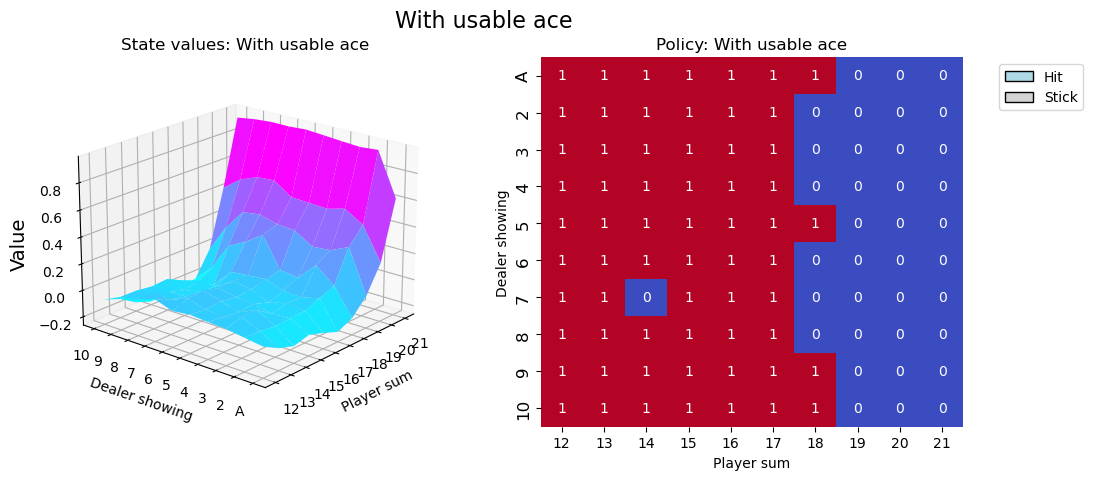

In [18]:
def create_grids(agent, usable_ace=False):
    """Create value and policy grid given an agent."""
    # convert our state-action values to state values
    # and build a policy dictionary that maps observations to actions
    state_value = defaultdict(float)
    policy = defaultdict(int)
    for obs, action_values in agent.q_values.items():
        state_value[obs] = float(np.max(action_values))
        policy[obs] = int(np.argmax(action_values))

    player_count, dealer_count = np.meshgrid(
        # players count, dealers face-up card
        np.arange(12, 22),
        np.arange(1, 11),
    )

    # create the value grid for plotting
    value = np.apply_along_axis(
        lambda obs: state_value[(obs[0], obs[1], usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )
    value_grid = player_count, dealer_count, value

    # create the policy grid for plotting
    policy_grid = np.apply_along_axis(
        lambda obs: policy[(obs[0], obs[1], usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )
    return value_grid, policy_grid


def create_plots(value_grid, policy_grid, title: str):
    """Creates a plot using a value and policy grid."""
    # create a new figure with 2 subplots (left: state values, right: policy)
    player_count, dealer_count, value = value_grid
    fig = plt.figure(figsize=plt.figaspect(0.4))
    fig.suptitle(title, fontsize=16)

    # plot the state values
    ax1 = fig.add_subplot(1, 2, 1, projection="3d")
    ax1.plot_surface(
        player_count,
        dealer_count,
        value,
        rstride=1,
        cstride=1,
        cmap="cool",
        edgecolor="none",
    )
    plt.xticks(range(12, 22), range(12, 22))
    plt.yticks(range(1, 11), ["A"] + list(range(2, 11)))
    ax1.set_title(f"State values: {title}")
    ax1.set_xlabel("Player sum")
    ax1.set_ylabel("Dealer showing")
    ax1.zaxis.set_rotate_label(False)
    ax1.set_zlabel("Value", fontsize=14, rotation=90)
    ax1.view_init(20, 220)

    # plot the policy
    fig.add_subplot(1, 2, 2)
    ax2 = sns.heatmap(policy_grid, linewidth=0, annot=True, cmap="coolwarm", cbar=False)
    ax2.set_title(f"Policy: {title}")
    ax2.set_xlabel("Player sum")
    ax2.set_ylabel("Dealer showing")
    ax2.set_xticklabels(range(12, 22))
    ax2.set_yticklabels(["A"] + list(range(2, 11)), fontsize=12)

    # add a legend
    legend_elements = [
        Patch(facecolor="lightblue", edgecolor="black", label="Hit"),
        Patch(facecolor="lightgrey", edgecolor="black", label="Stick"),
    ]
    ax2.legend(handles=legend_elements, bbox_to_anchor=(1.3, 1))
    return fig


# state values & policy with usable ace (ace counts as 11)
value_grid, policy_grid = create_grids(agent, usable_ace=True)
fig1 = create_plots(value_grid, policy_grid, title="With usable ace")
plt.show()

### Visualization 3 
The below code generates a 3D plot that shows the state values of the player's hand against the dealer's up card for the game of Blackjack, along with a heatmap that shows the optimal action to take given the player's hand and the dealer's up card.

The difference between this plot and the one generated with the usable ace is that in this case, the ace counts as 1 instead of 11. This makes a big difference in the strategy that the agent should use to play the game optimally.

These plots are useful for visualizing the strategy that the agent has learned and can be used to fine-tune the hyperparameters of the RL algorithm.

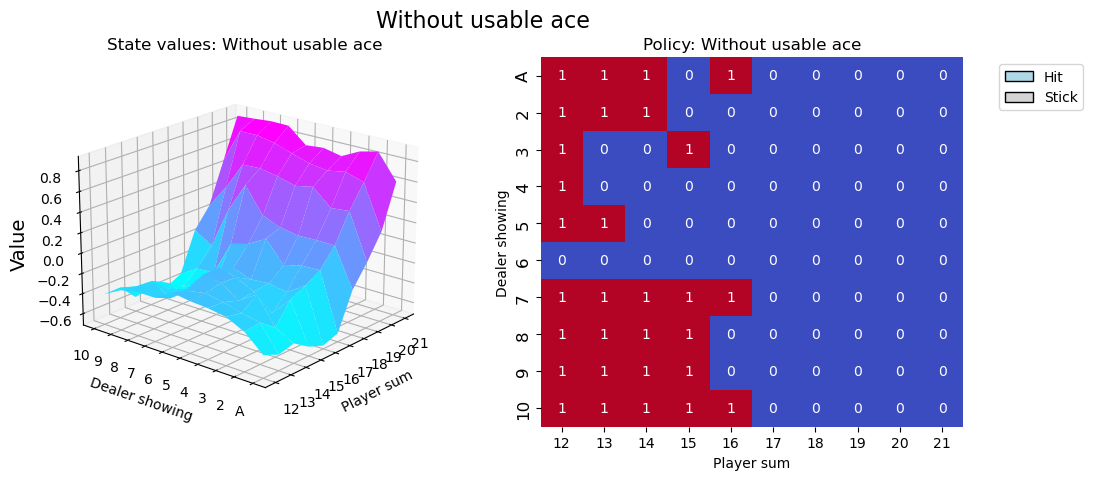

In [19]:
# state values & policy without usable ace (ace counts as 1)
value_grid, policy_grid = create_grids(agent, usable_ace=False)
fig2 = create_plots(value_grid, policy_grid, title="Without usable ace")
plt.show()

## Commentary on the above 2 sets of visuals

The two-state values graph shows the expected value of each state in the game of blackjack, where the state is defined by the player's sum, the dealer's up-card, and whether the player has a usable ace. The colors on these graphs indicate the value of the state, with cooler colors indicating lower values and warmer colors indicating higher values.

Unsurprisingly, hands with higher values are worth more. 

The two heat maps above allow us to get a sense of our agent’s policy when it plays the game. As we can see, the presence of a usable ace changes the decisions our agent makes.

From the first visual, we can see our agent always hits when they have a hand of seventeen or less. It was interesting that you only do not hit on fourteen if the dealer is showing seven. (This wont be present when you run it)

From the second visual, we see that we are much more apprehensive to hit. This is especially true for when the dealer is showing six.


## Result analysis 

We used the "Blackjack-v1" environment from OpenAI Gym to train a reinforcement learning agent, RLAgent2, to play Blackjack using the Q-Learning algorithm. Our agent learns an action-value function, Q(s, a), representing the expected value of taking an action 'a' in a given state 's', and explores the environment to find the optimal policy.

We experimented with hyperparameters such as learning rate, number of episodes, and exploration vs. exploitation trade-off, and arrived at the values listed in the code above. Our choices are consistent with common practices in reinforcement learning and have been effective in practice for the Blackjack environment.

Our agent's performance is near optimal, with an average reward per episode of -0.0671, a win rate of 0.4232, a draw rate of 0.0865, and a loss rate of 0.4903. These values are consistent with the theoretical odds of winning in a game of Blackjack.


Overall, our agent seems to be working well, and we have been able to train it to play Blackjack effectively using reinforcement learning.

# V. Conclusions

In this project, we used the Gym library from OpenAI to create a simulation of the popular casino game Blackjack. The Blackjack environment in Gym consists of an infinite deck of cards, with each card having a value from 1 to 11. The player's goal is to obtain cards with a higher sum than the dealer's hand without exceeding 21. The game ends when either the player or the dealer goes bust or when the player chooses to stick. The agent's objective is to learn a policy that maximizes the expected return over time by interacting with the environment.

We created an RL agent, RLAgent2, that learns to play the game using the Q-learning algorithm. RLAgent2 learns an action-value function representing the expected value of taking an action in a given state. The agent's hyperparameters were chosen through trial and error, including a learning rate of 0.01, 100,000 episodes, an initial epsilon of 1.0, an epsilon decay rate that reduces epsilon by half over time, and a final epsilon of 0.1.

The agent's performance was evaluated by running 10,000 episodes and calculating performance metrics such as the average reward per episode, win rate, draw rate, and loss rate. The agent's performance was found to be near-optimal, with a win rate of 42.32%, a draw rate of 8.65%, and a loss rate of 49.03%.

Finally, we plotted three graphs in one figure showing the moving average of the episode rewards, episode lengths, and training error over the course of the agent's training. The purpose of this visualization is to provide a clearer picture of the agent's performance trends over time.


Overall, our project showed the effectiveness of reinforcement learning in solving complex problems and highlighted the importance of choosing appropriate methods and hyperparameters for each problem.